# Hidden Markov Model Demo
Imagine you're in a haunted house, and you are woken in a bedroom by a noise above you in the attic. It is a ghost walking around! Our goal is to figure out where in the attic the ghost is. Perhaps so we could bust it.
- The ghost moves around every second (we discretise time).
- Floorboards will creak with a probability in the vicinity of where the ghost is.

Together, this defines a Hidden Markov Model:
- Ghost movement: $p(x_t|x_{t-1})$
- Floorboard creaking: $p(y_t|x_t)$
- Posterior of interest: $p(x_t|y_1,\dots,y_t)$

In our case, all these distributions are discrete. In the code we will represent $x_t$ and $y_t$ in two equivalent ways:
- As a pair of (y,x) coordinates in a vector.
- As a one-hot encoded location in a 2D grid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4)

In [2]:
# From Matplotlib documentation
def hinton(matrix, max_weight=1.0, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix.T + 1e-13):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
        
    ax.set_xticks(np.arange(1, width) - 0.5)
    ax.set_yticks(np.arange(1, height) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()

    ax.autoscale_view()
    ax.invert_yaxis()

Filtering
\begin{align}
p(x_t | y_1, \dots,y_{t-1}) &= \sum_{x_{t-1}} p(x_{t}|x_{t-1}) p(x_{t-1}|y_{t-1}) \\
p(x_t | y_1,\dots,y_{t}) &= \frac{p(y_t|x_t)p(x_t | y_{t-1})}{Z}
\end{align}

In [3]:
width = 12
height = 10
movement = True  # Does the person in the attic move?
obs_noise = 1  # How many cells can the creaking floorboord deviate from the location of the person?
obs_prob = 0.6  # What is the probability of a floorboard creaking?

In [4]:
def sample_transition(x):
    # x: 2-vector as [y, x] location
    # Samples from p(x_t|x_{t-1})
    if movement:
        delta = np.array([np.random.randint(-1, 2), np.random.randint(-1, 2)])
        if np.abs(delta).sum() == 2:
            delta = np.array([0, 0])  # So 5/9 probability of staying in the same spot
        x = (x + delta) % np.array([height, width])
    return x

def sample_observation(x):
    # x: 2-vector as [y, x] location
    # Samples from p(y_t|x_t)
    if np.random.rand() < obs_prob:
        delta = np.array([np.random.randint(-obs_noise, obs_noise+1), np.random.randint(-obs_noise, obs_noise+1)])
        x = (x + delta) % np.array([height, width])
        return x
    else:
        return None

In [5]:
xall = []  # Store list of [y, x] locations of states
yall = []  # Store list of observations. [y, x] if observation, None if nothing was heard
# x = np.array([np.random.randint(0, height), np.random.randint(0, width)])  # Start in a random location
x = np.array([height // 2, width // 2])  # Start in the middle
for t in range(10000):  # Simulate forward 10000 steps
    x = sample_transition(x)
    xall.append(x)
    yall.append(sample_observation(x))
xall = np.vstack(xall)

In [6]:
def visual(x, y=None):
    # Produce a 2D array visualisation of the state `x` and observation `y`
    # x: [y, x] location of the person
    # y: [y, x] location of the creaking floorboard
    img = np.zeros((height, width))
    img[x[0], x[1]] = 1
    if y is not None:
        img[y[0], y[1]] = 0.5
    return img

def plot_state(img):
    # Plot the 2D array visualisation
    fig, ax = plt.subplots()
    ims = ax.imshow(img, vmin=0, cmap='Greys_r')
    ax.set_xticks(np.arange(1, width) - 0.5)
    ax.set_yticks(np.arange(1, height) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    
def transition_prob(x):
    # Calculate p(x_t|X_{t-1}=x) for the given value x, and for all values of x_t.
    if movement:
        img = visual(x)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 or dy == 0:
                    img[(x[0] + dy) % height, (x[1] + dx) % width] = 1 / 9
        img[x[0], x[1]] = 5/9
        img = img / np.sum(img)  # Normalise probability
    return img

def observe_prob(x):
    # Calculate p(y_t|X_t=x) for the given value x, and for all values of y_t.
    img = visual(x)
    for dx in np.arange(-obs_noise, obs_noise+1):
        for dy in np.arange(-obs_noise, obs_noise+1):
            img[(x[0] + dy) % height, (x[1] + dx) % width] = 1
    img = img / np.sum(img)  # Normalise probability
    return img

def likelihood(y):
    # Calculate p(Y_t=y|x_t) for the given value y, and for all values of x_t.
    if y is not None:
        return observe_prob(y)
    else:
        return 1.0

def forward(p_xt):
    px_tp1 = np.zeros((height, width))
    for (y, x), w in np.ndenumerate(p_xt):
        px_tp1 = px_tp1 + transition_prob([y, x]) * w
    return px_tp1

## Visualising the Model
Let's first start by visualising where the person is standing.

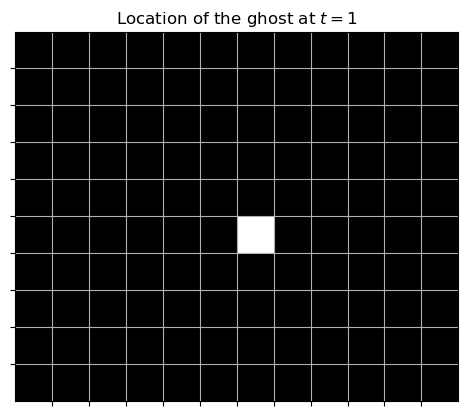

In [7]:
plot_state(visual(xall[0]))
plt.title("Location of the ghost at $t=1$");

### Transition Probability
Let's visualise the transition probability $p(x_t|x_{t-1})$ as a function of $x_t$, for a fixed value of $x_{t-1}$. We do this with a hinton diagram. These diagrams are often used to visualise the weights of neural networks. They use the area of a square to represent the strength of a signal, which in our case is the probability. This diagram helps since area is morea easily distinguishable than shade, particularly when probabilities are close to zero.

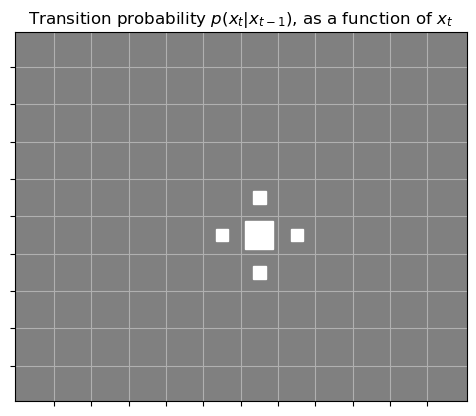

In [8]:
hinton(transition_prob([height // 2, width // 2]))
plt.title("Transition probability $p(x_t|x_{t-1})$, as a function of $x_t$");

### Observation Probability
Next, let's visualise the observation probability $p(y_t|x_t)$ as a function of $y_t$.

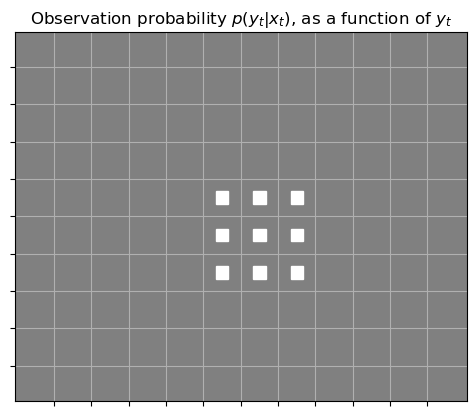

In [9]:
hinton(observe_prob([height // 2, width // 2]))
plt.title("Observation probability $p(y_t|x_t)$, as a function of $y_t$");

## Model, Prior, Likelihood

Before hearing any creaks, we start with a _prior_ distribution on where the person is $p(x_1)$. Since we just woke up, we represent our ignorance with a fully uniform distribution, i.e.
$$
p(x_1) = \frac{1}{\text{width}\cdot\text{height}}
$$

In [10]:
t = 0
post = np.ones((height, width)) / (height * width)

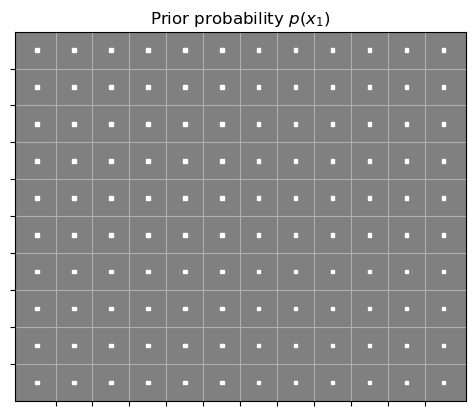

In [11]:
hinton(post)
plt.title("Prior probability $p(x_1)$");

Let's plot the latent state $x_t$, together with the observation $y_t$. The location of $x_t$ is in white, the location of the observed creak is $y_t$. (I chose a random seed to make sure that this plot contains an observation, since there is a probability of there not being an observation).

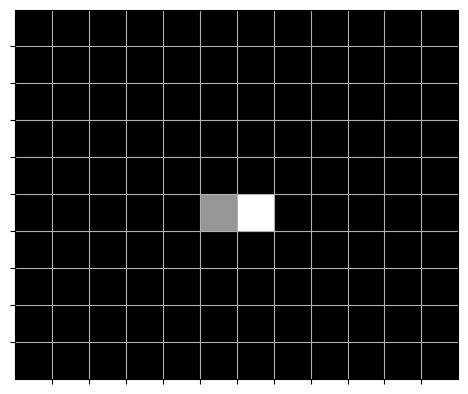

In [12]:
plot_state(visual(xall[t, :], yall[t]))

Let's update the prior to include the information that the first observation gives. I.e.:
$$
p(x_1|y_1) = \frac{p(y_1|x_1)p(x_1)}{p(y_1)}\,.
$$
Remember that $p(y_1)$ is just the normalising constant of the numerator, i.e.:
$$
p(y_1) = \sum_{x_1} p(y_1|x_1) p(x_1)\,.
$$

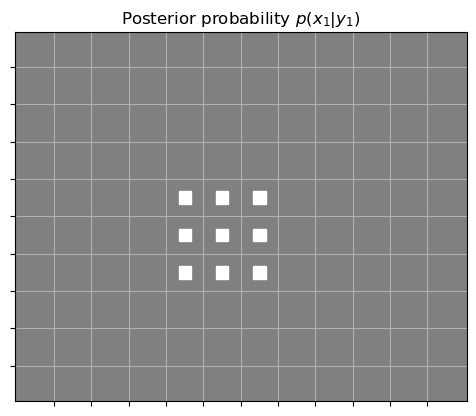

In [13]:
post = post * likelihood(yall[t])
post = post / post.sum()
hinton(post, max_weight=1.0)
plt.title("Posterior probability $p(x_1|y_1)$");

## Forward Prediction
To perform filtering, we first need to compute the prediction of the state at the next time point, i.e. $p(x_{t+1}|y_{1:t})$. We can find this as:
\begin{align}
p(x_{t+1}|y_{1:t}) &\stackrel{\text{AT}}{=} \sum_{x_t} p(x_{t+1},x_t|y_{1:t}) \\
&\stackrel{\text{AT}}{=} \sum_{x_t} p(x_{t+1}|x_t,y_{1:t}) p(x_t|y_{1:t}) \\
&\stackrel{\text{MA}}{=} \sum_{x_t} p(x_{t+1}|x_t) p(x_t|y_{1:t})
\end{align}
The final MA step, was done using the conditional independence obtained from the graphical model.

Here, this equation is implemented in the `forward()` function. If we plot the result, we see that we have become more uncertain! This makes sense, as the ghost could have taken a step.

0 [5 5]


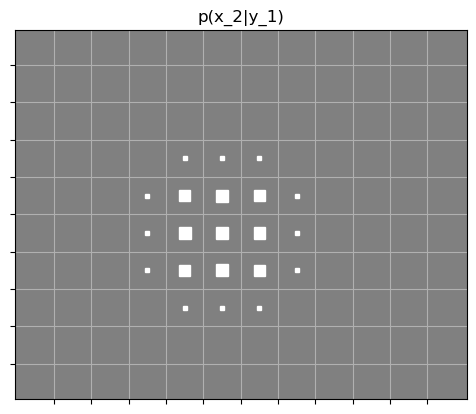

In [14]:
post = forward(post)
hinton(post, max_weight=1.0)
plt.title("p(x_2|y_1)")
print(t, yall[t])
t += 1  # Move onto the next timepoint.

## Bayesian Update
We can now update this predictive distribution to find the next posterior. Let's find the update:
\begin{align}
p(x_t|y_1\,\dots,y_t) &\stackrel{\text{AT}}{=} \frac{p(y_t,x_t,y_1,\dots,y_{t-1})}{p(y_1,\dots,y_{t})} \\
&\stackrel{\text{AT}}{=} \frac{p(y_t|x_t,y_1,\dots,y_{t-1}) p(x_t,y_1,\dots,y_{t-1})}{p(y_1,\dots,y_{t})} \\
&\stackrel{\text{AT}}{=} \frac{p(y_t|x_t,y_1,\dots,y_{t-1}) p(x_t|y_1,\dots,y_{t-1})}{p(y_t|y_1,\dots,y_{t-1})} \\
&\stackrel{\text{MA}}{=} \frac{p(y_t|x_t) p(x_t|y_1,\dots,y_{t-1})}{p(y_t|y_1,\dots,y_{t-1})}
\end{align}
Again, the denomenator in this fraction can be found by normalising the numerator over all the values of $x_t$, i.e.:
\begin{align}
p(y_t|y_1,\dots,y_{t-1}) &\stackrel{\text{AT}}{=} \sum_{x_t} p(y_t|x_t,y_1,\dots,y_{t-1}) p(x_t|y_1,\dots,y_{t-1}) \\
&\stackrel{\text{MA}}{=} \sum_{x_t} p(y_t|x_t) p(x_t|y_1,\dots,y_{t-1})
\end{align}

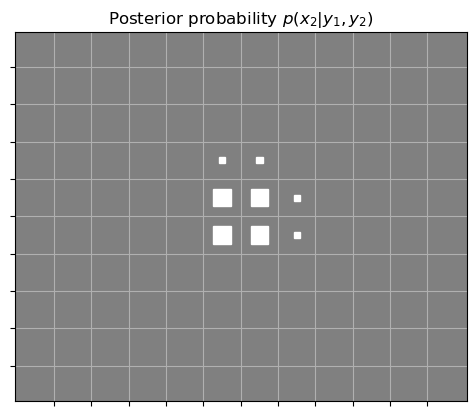

In [15]:
post = post * likelihood(yall[t])
post = post / post.sum()
hinton(post, max_weight=1.0)
plt.title("Posterior probability $p(x_2|y_1,y_2)$");

## Filtering: Repeated Updating
Run the cell below multiple times to do filtering.

2 [7 5]


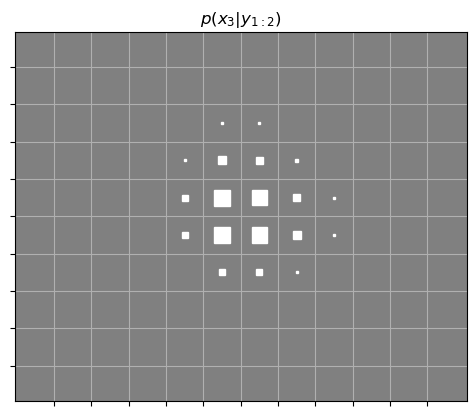

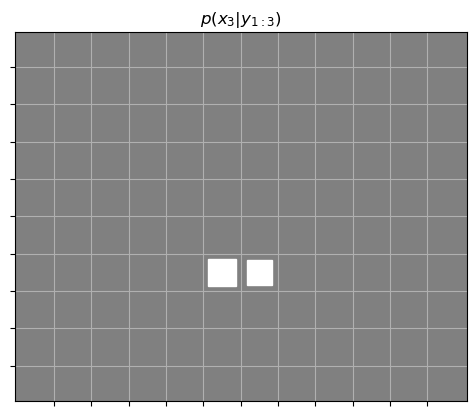

In [16]:
post = forward(post)
hinton(post, max_weight=1.0)
plt.title("$p(x_{"+str(t+2)+"}|y_{1:"+str(t+1)+"})$")
t += 1  # Move onto the next timepoint.
print(t, yall[t])
post = post * likelihood(yall[t])
post = post / post.sum()
plt.figure(); hinton(post, max_weight=1.0)
plt.title("$p(x_{"+str(t+1)+"}|y_{1:"+str(t+1)+"})$");